Make an Ising model with genes as nodes and capturing the HiC interactions between them

In [4]:
import argparse
import shutil
import h5py
import numpy as np
import pandas as pd
import cooler
import networkx as nx
import matplotlib.pyplot as plt
import json
import pickle
from tqdm import tqdm

In [82]:
######load HiC files######
c = cooler.Cooler('4DNFI18UHVRO_K562.mcool::/resolutions/20000')

#whole genome contact matrix as pandas df (reading as np array and not csr format as sparse=False)
matrix = c.matrix(balance=True, sparse=False, as_pixels=True, join=False, divisive_weights=None)[:] #pixels table is read as pd df
edge_list = matrix[['bin1_id', 'bin2_id', 'balanced']] #convert to numpy array

#remove self loops
edge_list = edge_list[edge_list['bin1_id']!=edge_list['bin2_id']]
print(edge_list)


         bin1_id  bin2_id  balanced
1              0       21  0.003500
2              0      248  0.000710
3              0      312  0.000174
4              0      492  0.000231
5              0      524  0.000193
...          ...      ...       ...
4233183     3055     3059  0.001243
4233184     3056     3100  0.002095
4233187     3059     3100  0.001684
4233189     3065     3100  0.006706
4233191     3070     3100  0.095168

[4230248 rows x 3 columns]


In [29]:
######load gene files######
#load norman's gene TSS pkl
with open('norman_TSS.pkl', 'rb') as handle:
    gene_tss = pickle.load(handle)
#remove the last 14 rows of the df (they are not genes we want)
gene_tss = gene_tss[:-14]
print(gene_tss)

        seqname        TSS strand          gene_id
99         chr1      91105      -  ENSG00000239945
703        chr1     921016      -  ENSG00000223764
714        chr1     923928      +  ENSG00000187634
1352       chr1     982093      -  ENSG00000187642
1384       chr1    1000172      -  ENSG00000188290
...         ...        ...    ...              ...
2732363    chrX  155334657      -  ENSG00000155962
2732467    chrX  155466540      +  ENSG00000224533
2732651    chrX  155997581      +  ENSG00000124334
2734639    chrY    5000226      +  ENSG00000099715
2738619    chrY   21044724      -  ENSG00000254488

[4987 rows x 4 columns]


In [36]:
########Assign bin id to each gene########

all_bins = c.bins()[:]
#print(all_bins)
genes_with_bins = []
for chr in range(1,23):
    chr_bins = all_bins[all_bins['chrom']=='chr'+str(chr)]
    chr_genes = gene_tss[gene_tss['seqname']=='chr'+str(chr)]
    gene_bins = []
    for i in range(len(chr_genes)):
        gene_bins.append(chr_bins[(chr_bins['start']<=chr_genes.iloc[i]['TSS']) & (chr_bins['end']>=chr_genes.iloc[i]['TSS'])].index[0])
    chr_genes.loc[:, 'bin_id'] = gene_bins
    genes_with_bins.append(chr_genes)

#do the same for chrX and chrY too
chr_bins = all_bins[all_bins['chrom']=='chrX']
chr_genes = gene_tss[gene_tss['seqname']=='chrX']
gene_bins = []
for i in range(len(chr_genes)):
    gene_bins.append(chr_bins[(chr_bins['start']<=chr_genes.iloc[i]['TSS']) & (chr_bins['end']>=chr_genes.iloc[i]['TSS'])].index[0])
chr_genes.loc[:, 'bin_id'] = gene_bins
genes_with_bins.append(chr_genes)

chr_bins = all_bins[all_bins['chrom']=='chrY']
chr_genes = gene_tss[gene_tss['seqname']=='chrY']
gene_bins = []
for i in range(len(chr_genes)):
    gene_bins.append(chr_bins[(chr_bins['start']<=chr_genes.iloc[i]['TSS']) & (chr_bins['end']>=chr_genes.iloc[i]['TSS'])].index[0])
chr_genes.loc[:, 'bin_id'] = gene_bins
genes_with_bins.append(chr_genes)

#concatenate all the dfs
genes_with_bins = pd.concat(genes_with_bins)


/var/folders/tb/s68l7gcj6rg4952d2x7x3jd80000gn/T/ipykernel_86094/581820771.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_genes.loc[:, 'bin_id'] = gene_bins
/var/folders/tb/s68l7gcj6rg4952d2x7x3jd80000gn/T/ipykernel_86094/581820771.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_genes.loc[:, 'bin_id'] = gene_bins
/var/folders/tb/s68l7gcj6rg4952d2x7x3jd80000gn/T/ipykernel_86094/581820771.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

        seqname        TSS strand          gene_id  bin_id
99         chr1      91105      -  ENSG00000239945       0
703        chr1     921016      -  ENSG00000223764       0
714        chr1     923928      +  ENSG00000187634       0
1352       chr1     982093      -  ENSG00000187642       0
1384       chr1    1000172      -  ENSG00000188290       0
...         ...        ...    ...              ...     ...
2732363    chrX  155334657      -  ENSG00000155962     315
2732467    chrX  155466540      +  ENSG00000224533     315
2732651    chrX  155997581      +  ENSG00000124334     315
2734639    chrY    5000226      +  ENSG00000099715     316
2738619    chrY   21044724      -  ENSG00000254488     318

[4987 rows x 5 columns]


/var/folders/tb/s68l7gcj6rg4952d2x7x3jd80000gn/T/ipykernel_86094/581820771.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_genes.loc[:, 'bin_id'] = gene_bins
/var/folders/tb/s68l7gcj6rg4952d2x7x3jd80000gn/T/ipykernel_86094/581820771.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr_genes.loc[:, 'bin_id'] = gene_bins
/var/folders/tb/s68l7gcj6rg4952d2x7x3jd80000gn/T/ipykernel_86094/581820771.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [74]:
#select the unique bin ids from the gene tss list 
gene_bins = genes_with_bins['bin_id'].unique()
#filter out the egdes between these gene_bins from the edge_list 
edge_list_genes = edge_list[edge_list['bin1_id'].isin(gene_bins) & edge_list['bin2_id'].isin(gene_bins)]
#update the idx of edge list to start from 0 till len
edge_list_genes = edge_list_genes.reset_index(drop=True)
print(edge_list_genes)

       bin1_id  bin2_id  balanced
0            0        2  0.027827
1            0       24  0.008854
2            0       31  0.002615
3            0       50  0.002689
4            0       53  0.002310
...        ...      ...       ...
48194      314      315  0.172070
48195      314      318       NaN
48196      314      316  0.008354
48197      315      316  0.002267
48198      315      318       NaN

[48199 rows x 3 columns]


In [86]:
#create a df with columns 'bin_id' and list of genes in that bin from genes_with_bins
genes_inside_bins = genes_with_bins.groupby('bin_id')['gene_id'].apply(list).reset_index(name='genes')
print(genes_inside_bins)


     bin_id                                              genes
0         0  [ENSG00000239945, ENSG00000223764, ENSG0000018...
1         1  [ENSG00000142657, ENSG00000175262, ENSG0000027...
2         2  [ENSG00000117215, ENSG00000187980, ENSG0000011...
3         3  [ENSG00000162511, ENSG00000121769, ENSG0000023...
4         4  [ENSG00000131236, ENSG00000049089, ENSG0000017...
..      ...                                                ...
306     313  [ENSG00000134594, ENSG00000165694, ENSG0000023...
307     314  [ENSG00000134595, ENSG00000196406, ENSG0000004...
308     315  [ENSG00000214915, ENSG00000166049, ENSG0000022...
309     316                                  [ENSG00000099715]
310     318                                  [ENSG00000254488]

[311 rows x 2 columns]
     bin_id            genes
0         0  ENSG00000239945
0         0  ENSG00000223764
0         0  ENSG00000187634
0         0  ENSG00000187642
0         0  ENSG00000188290
..      ...              ...
308     315  ENSG

In [81]:
# Initialize a list to collect new gene-gene edges
new_edges_list = []

# Iterate through each edge in edges_df
#add tqdm to show progress bar
for _, edge in edge_list_genes.iterrows():
    # Get the genes in each bin
    left_genes = genes_inside_bins['genes'][genes_inside_bins['bin_id'] == edge['bin1_id']].iloc[0]
    right_genes = genes_inside_bins['genes'][genes_inside_bins['bin_id'] == edge['bin2_id']].iloc[0]
    # Calculate the weight for each new edge
    total_new_edges = len(left_genes) * len(right_genes)
    if total_new_edges == 0:
        continue  # Skip if no genes in either bin
    new_weight = edge['balanced'] / total_new_edges
    #don't add edge is new_weight is NaN
    if np.isnan(new_weight):
        continue
    # Iterate through the left and right genes to create new edges
    for left_gene in left_genes:
        for right_gene in right_genes:
            # Append the new edges to the list
            new_edges_list.append([left_gene, right_gene, new_weight])

# Create a DataFrame from the new edges
new_edges_df = pd.DataFrame(new_edges_list, columns=['gene1', 'gene2', 'weight'])

print(new_edges_df)

                    gene1            gene2    weight
0         ENSG00000239945  ENSG00000117215  0.000014
1         ENSG00000239945  ENSG00000187980  0.000014
2         ENSG00000239945  ENSG00000117242  0.000014
3         ENSG00000239945  ENSG00000236936  0.000014
4         ENSG00000239945  ENSG00000142789  0.000014
...                   ...              ...       ...
12144252  ENSG00000160219  ENSG00000099715  0.000091
12144253  ENSG00000203870  ENSG00000099715  0.000091
12144254  ENSG00000155962  ENSG00000099715  0.000091
12144255  ENSG00000224533  ENSG00000099715  0.000091
12144256  ENSG00000124334  ENSG00000099715  0.000091

[12144257 rows x 3 columns]


In [87]:
#dict of graph indices for the genes {key(gene name):value(idx in node list)} to guide the graph
import pickle
import os
import sys

#open the pickle file
with open('norman_node_map.pkl', 'rb') as handle:
    indices = pickle.load(handle)
#load the gene_name and gene_id mapping norman_gene_names.csv 
map_g2e = pd.read_csv('norman_gene_names.csv')
#replace the keys in indices dict from gene_name to gene_id using map_g2e
indices = {map_g2e[map_g2e['gene_name']==k]['gene_id'].iloc[0]:v for k,v in indices.items()}


{'RP11-34P13.8': 0, 'RP11-54O7.3': 1, 'SAMD11': 2, 'PERM1': 3, 'HES4': 4, 'ISG15': 5, 'RP11-54O7.18': 6, 'RNF223': 7, 'LINC01342': 8, 'TTLL10-AS1': 9, 'TNFRSF18': 10, 'TNFRSF4': 11, 'TAS1R3': 12, 'ANKRD65': 13, 'MMP23B': 14, 'RP11-345P4.7': 15, 'CALML6': 16, 'RP5-892K4.1': 17, 'RP11-181G12.4': 18, 'PLCH2': 19, 'RP3-395M20.12': 20, 'RP3-395M20.8': 21, 'TNFRSF14': 22, 'TTC34': 23, 'TP73': 24, 'SMIM1': 25, 'RP1-286D6.5': 26, 'CHD5': 27, 'LINC00337': 28, 'GPR153': 29, 'HES2': 30, 'ESPN': 31, 'TAS1R1': 32, 'RP11-338N10.1': 33, 'TNFRSF9': 34, 'RP5-1115A15.1': 35, 'RP4-633I8.4': 36, 'ENO1': 37, 'CA6': 38, 'GPR157': 39, 'MIR34AHG': 40, 'RP3-510D11.2': 41, 'H6PD': 42, 'PIK3CD-AS1': 43, 'AL357140.1': 44, 'PGD': 45, 'C1orf127': 46, 'RP4-635E18.9': 47, 'MASP2': 48, 'RP4-635E18.8': 49, 'SRM': 50, 'DRAXIN': 51, 'MTHFR': 52, 'PDPN': 53, 'TMEM51-AS1': 54, 'RP3-467K16.2': 55, 'RP3-467K16.4': 56, 'EFHD2': 57, 'CELA2A': 58, 'CELA2B': 59, 'RP4-680D5.9': 60, 'RP11-276H7.3': 61, 'RP4-798A10.7': 62, 'RP5-118

In [92]:
#create an adjacency matrix numpy array with nodes as indices keys and edges coming from the new_edges_df
# wherever there is no edges, keep weight as 0 between the nodes
#initialize the adj matrix with zeros
adj = np.zeros((len(indices), len(indices)))
#iterate through the new_edges_df and add the weights to the adj matrix
for _, edge in new_edges_df.iterrows():
    #get the idx of the genes from the indices dict
    idx1 = indices[edge['gene1']]
    idx2 = indices[edge['gene2']]
    #add the weight to the adj matrix
    adj[idx1][idx2] = edge['weight']
    adj[idx2][idx1] = edge['weight']


377.5833126674181


In [93]:
#save the adj matrix as a npy file
print(adj.sum().sum())
np.save('adj_matrix_norman_20kb.npy', adj)

377.5833126674181


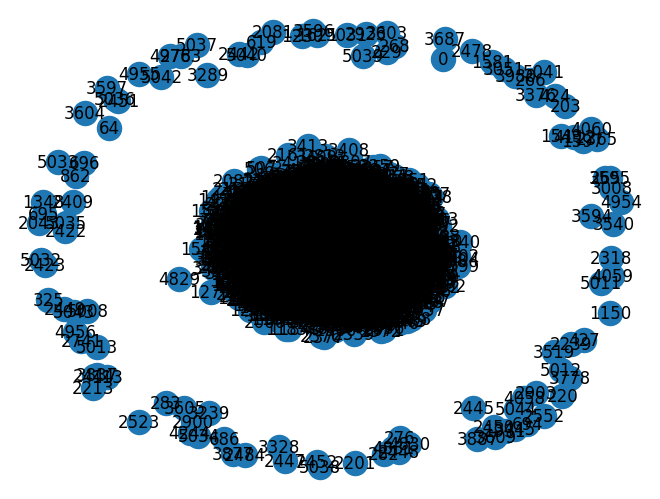

In [105]:
#load the adj matrix
adj = np.load('adj_matrix_norman_25kb.npy')
#plot the adj matrix as a graph
G = nx.from_numpy_array(adj)



/Users/Akanksha/anaconda3/envs/hubs1/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


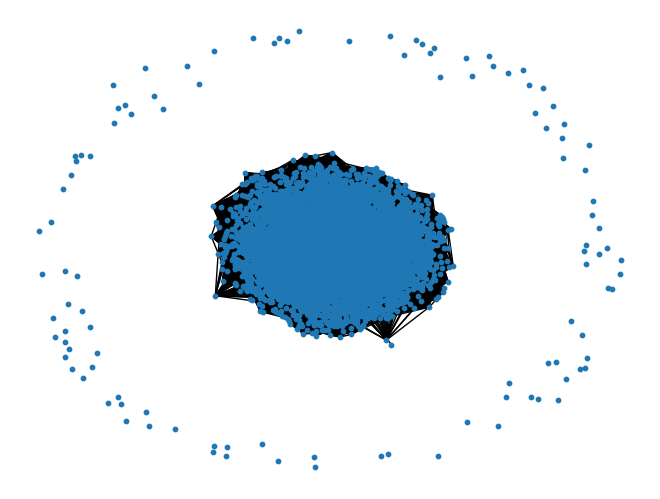

In [107]:
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=10, cmap=plt.cm.RdYlBu, with_labels=False)

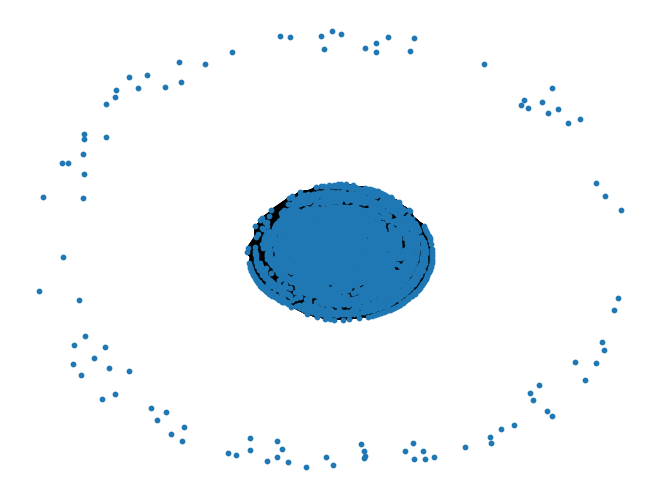

In [108]:
#load the adj matrix
adj = np.load('adj_matrix_norman_10Mb.npy')
#plot the adj matrix as a graph
G = nx.from_numpy_array(adj)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=10, cmap=plt.cm.RdYlBu, with_labels=False)

/var/folders/tb/s68l7gcj6rg4952d2x7x3jd80000gn/T/ipykernel_86094/647318756.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Test MSE', data=df, palette=colors)


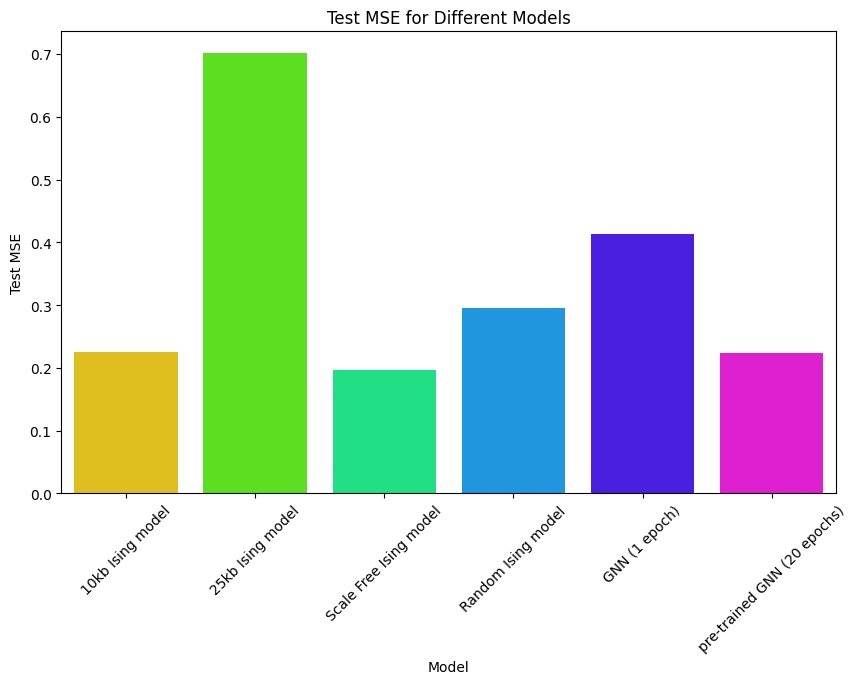

/var/folders/tb/s68l7gcj6rg4952d2x7x3jd80000gn/T/ipykernel_86094/647318756.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Train MSE', data=df, palette=colors)


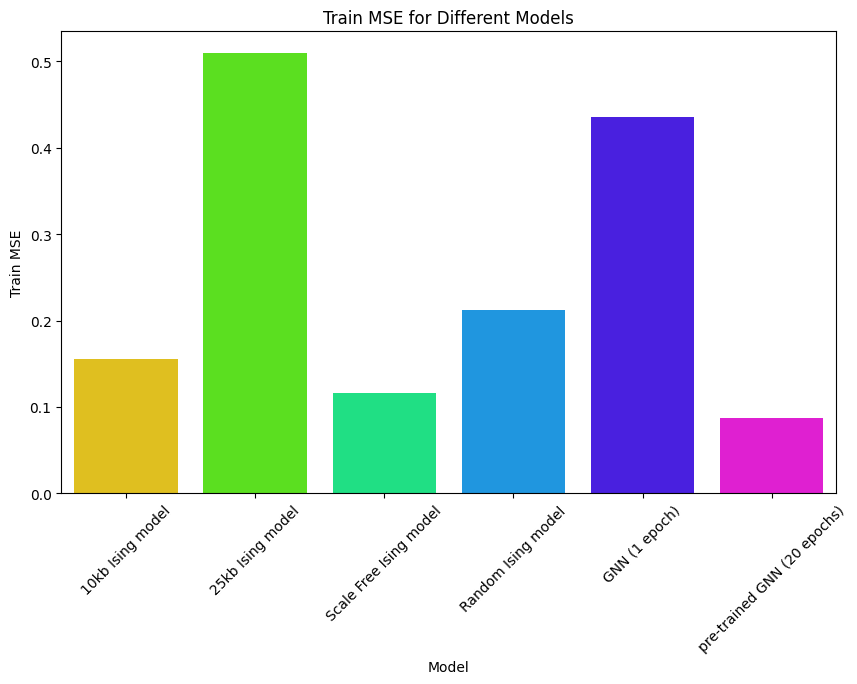

/var/folders/tb/s68l7gcj6rg4952d2x7x3jd80000gn/T/ipykernel_86094/647318756.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Validation', data=df, palette=colors)


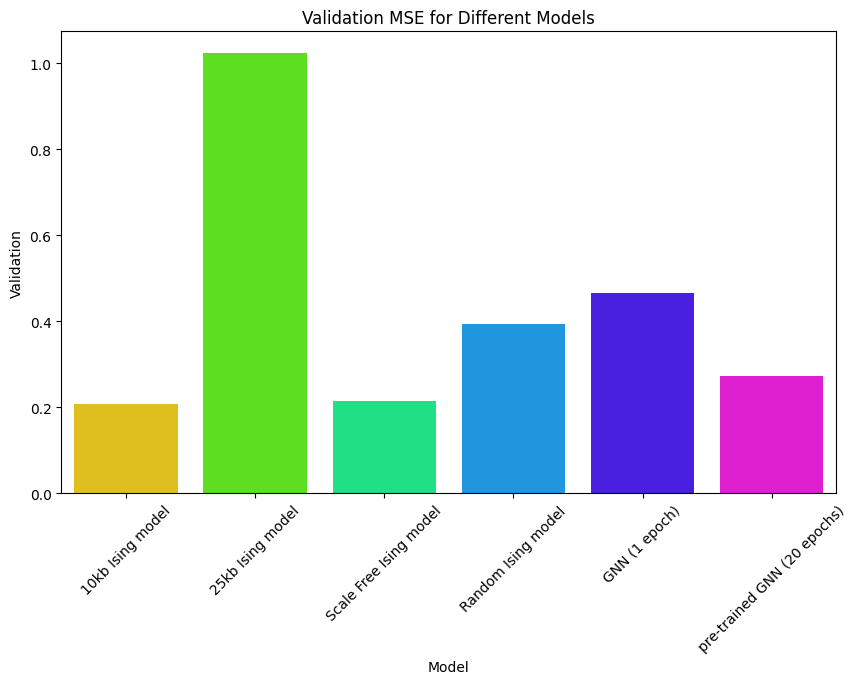

In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Prepare the Data
data = {
    'Model': ['10kb Ising model', '25kb Ising model', 'Scale Free Ising model', 'Random Ising model', 'GNN (1 epoch)', 'pre-trained GNN (20 epochs)'],
    'Test MSE': [0.225, 0.701, 0.197, 0.295, 0.413, 0.224],
    'Train MSE': [0.155, 0.509, 0.116, 0.212, 0.436, 0.0878],
    'Validation': [0.207, 1.023, 0.215, 0.393, 0.465, 0.273]
}

df = pd.DataFrame(data)

# Define a color palette
colors = sns.color_palette('hsv', len(df['Model']))

# Step 2: Plotting with Seaborn
# Test MSE Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Test MSE', data=df, palette=colors)
plt.title('Test MSE for Different Models')
plt.xticks(rotation=45)
plt.show()

# Train MSE Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Train MSE', data=df, palette=colors)
plt.title('Train MSE for Different Models')
plt.xticks(rotation=45)
plt.show()

# Validation MSE Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Validation', data=df, palette=colors)
plt.title('Validation MSE for Different Models')
plt.xticks(rotation=45)
plt.show()
